# Pitch Type Classification
### Classify Unlabeled Trackman Data Into Pitch Type Clusters

## Background
#### Trackman
Trackman ia a radar-based system installed in all Major League Baseball stadiums that records various measures on every pitch thrown. The system records the location of the pitch 100 times per second, and uses those locations to calculate measures on each pitch such as velocity,  break (horizontal and vertical movement off the pitch's initial trajectory) spin rate, spin direction and many others.

#### Pitch Types
Every pitcher throws a distinct number of pitch types, and these pitch types are manually classified in the data released by MLB. However information about pitch types can be gleaned from the measures in the Trackman data. For example how fastballs have a higher velocity than curveballs, or how sliders and curveballs move to the pitcher's non-throwing-arm side, while fastballs and changeups move to the pitcher's throwing-arm side.

#### Clustering
Given the knowledge that a pitcher throws only a finite number of pitch types, unlabeled Trackman data can be clustered into these distinct pitch types based on the measures found in the Trackman data. The end-goal is that automated labeling using Machine Learning methods can yield more accurate pitch labels than the manually tagged labels provided by MLB.

## Data Prep and Exploration

Import the data into a DataFrame

In [2]:
import pandas as pd
tm = pd.read_csv("./single_pitcher_trackman.csv").dropna(axis = 0) # remove rows with missing values
tm.head()

,velo,horz_break,vert_break,spin_rate
0,96.5,-0.4274,1.4193,2233.0
1,98.0,-0.4037,1.4747,2346.0
2,87.7,-0.9222,1.0514,1568.0
3,89.2,-1.3025,0.5730,1479.0
4,97.5,-0.3239,1.5167,2285.0


In [14]:
len(tm.index)

2988

There are only 4 features, and horz_break and vert are really different dimensions of the same feature. So to get an idea of our data let's just plot a few combinations of these features together. 

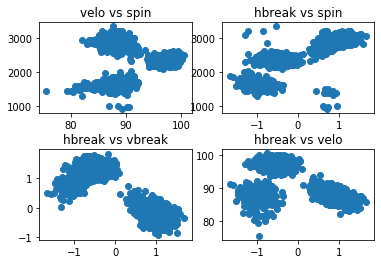

In [15]:
import matplotlib.pyplot as plt
plt.subplot(2,2,1)
plt.scatter(tm.velo,tm.spin_rate)
plt.title('velo vs spin')
plt.subplot(2,2,3)
plt.scatter(tm.horz_break,tm.vert_break)
plt.title('hbreak vs vbreak')
plt.subplot(2,2,4)
plt.scatter(tm.horz_break,tm.velo)
plt.title('hbreak vs velo')
plt.subplot(2,2,2)
plt.scatter(tm.horz_break,tm.spin_rate)
plt.title('hbreak vs spin')
plt.subplots_adjust(hspace=0.4)
plt.show()

## Classification

It looks like there are 3 clusters (possibly a 4th), which is more clear in some dimensions than others. Let's try to classify these features using K-means clustering with 3 clusters, and see how the algorithm does.

In [16]:
from sklearn.cluster import KMeans
tm['cluster'] = KMeans(n_clusters=3, random_state=0).fit_predict(tm)
tm.groupby('cluster').mean()

,velo,horz_break,vert_break,spin_rate
cluster,,,,
0,97.420887,-0.509747,1.339016,2368.381392
1,88.114977,-0.919837,0.850348,1615.652074
2,87.886359,0.862750,-0.201097,2911.068743


The means look reasonable (0 is probably a fastball, 1 would be changeup and 2 would be a slider). Let's recreate the same plots as above colored by cluster to see if we think the clustering is correct. 

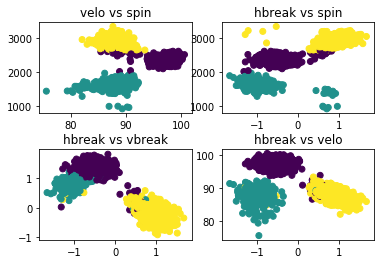

In [17]:
plt.subplot(2,2,1)
plt.scatter(tm.velo,tm.spin_rate,c = tm.cluster)
plt.title('velo vs spin')
plt.subplot(2,2,3)
plt.scatter(tm.horz_break,tm.vert_break,c = tm.cluster)
plt.title('hbreak vs vbreak')
plt.subplot(2,2,4)
plt.scatter(tm.horz_break,tm.velo,c = tm.cluster)
plt.title('hbreak vs velo')
plt.subplot(2,2,2)
plt.scatter(tm.horz_break,tm.spin_rate,c = tm.cluster)
plt.title('hbreak vs spin')
plt.subplots_adjust(hspace=0.4)
plt.show()

Based on the Velo vs Spin plot, it looks like K-means is overvaluing spin rate and undervaluing velocity. This is most likely due to the higher variance for Spin Rate compared to Velocity. To account for this, we'll repeat the clustering with normalized data.

In [18]:
from sklearn.preprocessing import scale
tm_scaled = scale(tm.loc[:,['velo','spin_rate','vert_break','horz_break']])
tm['cluster2'] = KMeans(n_clusters=3, random_state=0).fit_predict(tm_scaled)
tm.groupby('cluster2').mean()

,velo,horz_break,vert_break,spin_rate,cluster
cluster2,,,,,
0,97.582087,-0.531062,1.364799,2365.758014,0.002514
1,87.932986,0.856759,-0.193916,2899.181061,1.933403
2,88.122706,-0.921411,0.848649,1617.538991,0.995413


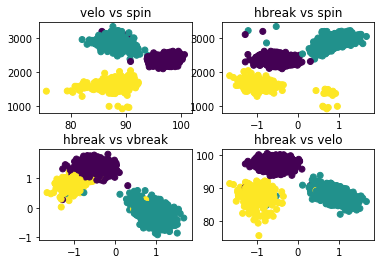

In [19]:
plt.subplot(2,2,1)
plt.scatter(tm.velo,tm.spin_rate,c = tm.cluster2)
plt.title('velo vs spin')
plt.subplot(2,2,3)
plt.scatter(tm.horz_break,tm.vert_break,c = tm.cluster2)
plt.title('hbreak vs vbreak')
plt.subplot(2,2,4)
plt.scatter(tm.horz_break,tm.velo,c = tm.cluster2)
plt.title('hbreak vs velo')
plt.subplot(2,2,2)
plt.scatter(tm.horz_break,tm.spin_rate,c = tm.cluster2)
plt.title('hbreak vs spin')
plt.subplots_adjust(hspace=0.4)
plt.show()

These clusters look to be by and large correct, although a few pitches are still debateable. Next we'll try to get similar results without knowing the cluster size. To do this we'll use DBSCAN clustering using euclidian distances.

To get an idea of what our parameters should be, it's helpful to see what our scaled data looks like (since that's the data we're fitting), so let's recreate out plots using the scaled data.

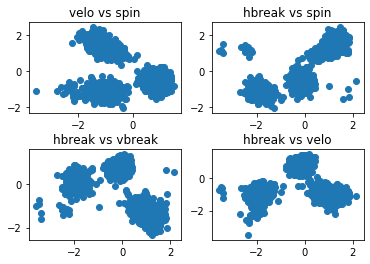

In [20]:
# convert tm_scaled to a dataframe so we can use it like tm with pyplot
tm_scaled = pd.DataFrame(tm_scaled,columns = tm.columns[0:4])

plt.subplot(2,2,1)
plt.scatter(tm_scaled.velo,tm_scaled.spin_rate)
plt.title('velo vs spin')
plt.subplot(2,2,3)
plt.scatter(tm_scaled.horz_break,tm_scaled.vert_break)
plt.title('hbreak vs vbreak')
plt.subplot(2,2,4)
plt.scatter(tm_scaled.horz_break,tm_scaled.velo)
plt.title('hbreak vs velo')
plt.subplot(2,2,2)
plt.scatter(tm_scaled.horz_break,tm_scaled.spin_rate)
plt.title('hbreak vs spin')
plt.subplots_adjust(hspace=0.4)
plt.show()

In [21]:
from sklearn.cluster import DBSCAN
tm['cluster3'] = DBSCAN(eps = 1).fit_predict(scale(tm_scaled))
tm.groupby('cluster3').mean()

,velo,horz_break,vert_break,spin_rate,cluster,cluster2
cluster3,,,,,,
-1,87.320000,-0.928300,0.745800,3145.800000,2.000000,0.600000
0,97.598552,-0.530909,1.365940,2364.802267,0.000000,0.000000
1,88.082423,-0.979897,0.880695,1630.415677,0.995249,2.000000
2,87.939103,0.861472,-0.195829,2897.809176,1.931178,0.998957
3,89.253333,0.720080,-0.050780,1256.133333,1.000000,2.000000


In [22]:
# determine how many outliers were identified
len(tm[tm.cluster3 == -1])

5

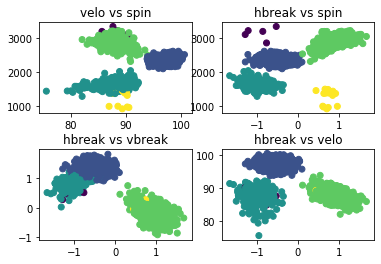

In [23]:
plt.subplot(2,2,1)
plt.scatter(tm.velo,tm.spin_rate,c = tm.cluster3)
plt.title('velo vs spin')
plt.subplot(2,2,3)
plt.scatter(tm.horz_break,tm.vert_break,c = tm.cluster3)
plt.title('hbreak vs vbreak')
plt.subplot(2,2,4)
plt.scatter(tm.horz_break,tm.velo,c = tm.cluster3)
plt.title('hbreak vs velo')
plt.subplot(2,2,2)
plt.scatter(tm.horz_break,tm.spin_rate,c = tm.cluster3)
plt.title('hbreak vs spin')
plt.subplots_adjust(hspace=0.4)
plt.show()